### 預測使用者是否會聽完整首 Spotify 歌曲

## 目標

##### 建立一個基礎的分類模型，預測一首歌播放時，使用者是否會跳過（skipped=True），並探索影響播放行為的因素。

## 簡介

##### Spotify播放紀錄資料集。

##### 欄位說明:

##### ms_played:播放時間（毫秒）——核心特徵

##### platform:播放平台（類別特徵）

##### reason_start:播放觸發方式（使用者點擊、autoplay）

##### reason_end:播放結束方式（如跳過、播放完）

##### shuffle:是否開啟隨機播放（布林）

##### ts:時間戳記，可延伸為「播放時段」

##### spotify_track_uri:Spotify 為每首歌曲分配的唯一識別碼（URI）

##### track_name:播放的歌曲名稱

##### artist_name:該曲目的主唱或樂團名稱

##### album_name:曲目所屬的專輯名稱

##### skipped:一個布林值，表示該曲目是否被使用者跳過（True 為跳過，False 為完整播放）

### 讀取數據

#### 評估數據結構

In [9]:
import pandas as pd
import numpy as np

In [10]:
original_data=pd.read_csv("spotify_history.csv")
original_data.head()

,spotify_track_uri,ts,platform,ms_played,track_name,artist_name,album_name,reason_start,reason_end,shuffle,skipped
0,2J3n32GeLmMjwuAzyhcSNe,2013-07-08 02:44:34,web player,3185,"Say It, Just Say It",The Mowgli's,Waiting For The Dawn,autoplay,clickrow,False,False
1,1oHxIPqJyvAYHy0PVrDU98,2013-07-08 02:45:37,web player,61865,Drinking from the Bottle (feat. Tinie Tempah),Calvin Harris,18 Months,clickrow,clickrow,False,False
2,487OPlneJNni3NWC8SYqhW,2013-07-08 02:50:24,web player,285386,Born To Die,Lana Del Rey,Born To Die - The Paradise Edition,clickrow,unknown,False,False
3,5IyblF777jLZj1vGHG2UD3,2013-07-08 02:52:40,web player,134022,Off To The Races,Lana Del Rey,Born To Die - The Paradise Edition,trackdone,clickrow,False,False
4,0GgAAB0ZMllFhbNc3mAodO,2013-07-08 03:17:52,web player,0,Half Mast,Empire Of The Sun,Walking On A Dream,clickrow,nextbtn,False,False


##### 數據結構符合一列爲一個觀察值，每一欄為一個變數。

#### 評估數據乾淨度

In [13]:
cleaned_data=original_data.copy()
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149860 entries, 0 to 149859
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   spotify_track_uri  149860 non-null  object
 1   ts                 149860 non-null  object
 2   platform           149860 non-null  object
 3   ms_played          149860 non-null  int64 
 4   track_name         149860 non-null  object
 5   artist_name        149860 non-null  object
 6   album_name         149860 non-null  object
 7   reason_start       149717 non-null  object
 8   reason_end         149743 non-null  object
 9   shuffle            149860 non-null  bool  
 10  skipped            149860 non-null  bool  
dtypes: bool(2), int64(1), object(8)
memory usage: 10.6+ MB


##### reason_start,reason_end存在缺失值，使用邏輯分析時不可存在缺失值，因此需移除。
##### ts資料型態需改為時間。
##### shuffle資料型態改為種類。

In [15]:
cleaned_data["ts"]=pd.to_datetime(cleaned_data["ts"])

In [16]:
cleaned_data["ts"]

0        2013-07-08 02:44:34
1        2013-07-08 02:45:37
2        2013-07-08 02:50:24
3        2013-07-08 02:52:40
4        2013-07-08 03:17:52
                 ...        
149855   2024-12-15 23:06:19
149856   2024-12-15 23:06:21
149857   2024-12-15 23:06:22
149858   2024-12-15 23:06:23
149859   2024-12-15 23:06:25
Name: ts, Length: 149860, dtype: datetime64[ns]

In [17]:
cleaned_data=cleaned_data.dropna(subset="reason_start")

In [18]:
cleaned_data=cleaned_data.dropna(subset="reason_end")

In [19]:
print(cleaned_data["reason_start"].isnull().sum())
print(cleaned_data["reason_end"].isnull().sum())

0
0


In [20]:
cleaned_data["shuffle"]=cleaned_data["shuffle"].astype("category")

#### 評估不一致數據

In [22]:
cleaned_data["platform"].value_counts()

platform
android           139821
cast to device      3893
iOS                 2842
windows             1691
mac                 1176
web player           225
Name: count, dtype: int64

In [23]:
cleaned_data["reason_start"].value_counts()

reason_start
trackdone     76599
fwdbtn        53785
clickrow      11224
appload        3729
backbtn        2204
playbtn        1458
remote          477
trackerror      120
unknown          23
nextbtn          21
popup             5
endplay           2
autoplay          1
Name: count, dtype: int64

In [24]:
cleaned_data["reason_end"].value_counts()

reason_end
trackdone                       77110
fwdbtn                          53462
endplay                         10116
logout                           4367
backbtn                          2182
unexpected-exit-while-paused     1725
unknown                           268
remote                            224
unexpected-exit                   118
clickrow                           34
nextbtn                            21
appload                             7
popup                               6
reload                              4
trackerror                          4
Name: count, dtype: int64

In [25]:
cleaned_data["shuffle"].value_counts()

shuffle
True     111548
False     38100
Name: count, dtype: int64

#### 評估重複數據

In [27]:
cleaned_data=cleaned_data.drop_duplicates()

#### 處理無效或錯誤數據

In [29]:
cleaned_data.describe()

,ts,ms_played
count,148463,1.484630e+05
mean,2020-04-18 21:06:41.226285312,1.280384e+05
min,2013-07-08 02:44:34,0.000000e+00
25%,2018-02-03 21:30:42,2.780000e+03
50%,2020-08-03 00:57:05,1.383860e+05
75%,2021-12-31 23:38:02.500000,2.183070e+05
max,2024-12-15 23:06:25,1.561125e+06
std,NaN,1.178061e+05


並未有脫離現實意義的數字。

### 整理數據

##### 新增hour欄位，取出播放時段更有利後續探索數據。

In [33]:
cleaned_data['hour'] = cleaned_data['ts'].dt.hour
cleaned_data.head()

,spotify_track_uri,ts,platform,ms_played,track_name,artist_name,album_name,reason_start,reason_end,shuffle,skipped,hour
0,2J3n32GeLmMjwuAzyhcSNe,2013-07-08 02:44:34,web player,3185,"Say It, Just Say It",The Mowgli's,Waiting For The Dawn,autoplay,clickrow,False,False,2
1,1oHxIPqJyvAYHy0PVrDU98,2013-07-08 02:45:37,web player,61865,Drinking from the Bottle (feat. Tinie Tempah),Calvin Harris,18 Months,clickrow,clickrow,False,False,2
2,487OPlneJNni3NWC8SYqhW,2013-07-08 02:50:24,web player,285386,Born To Die,Lana Del Rey,Born To Die - The Paradise Edition,clickrow,unknown,False,False,2
3,5IyblF777jLZj1vGHG2UD3,2013-07-08 02:52:40,web player,134022,Off To The Races,Lana Del Rey,Born To Die - The Paradise Edition,trackdone,clickrow,False,False,2
4,0GgAAB0ZMllFhbNc3mAodO,2013-07-08 03:17:52,web player,0,Half Mast,Empire Of The Sun,Walking On A Dream,clickrow,nextbtn,False,False,3


### 探索數據

#### 使用者跳過歌曲的比例

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("pastel")

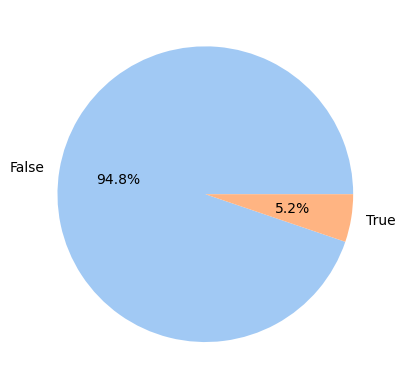

In [37]:
skipped_count=cleaned_data["skipped"].value_counts()
skipped_labels=skipped_count.index
plt.pie(skipped_count,labels=skipped_labels,autopct='%.1f%%')
plt.show()

##### 使用者跳過歌曲的比例為5.2%。

#### 歌曲播放時長

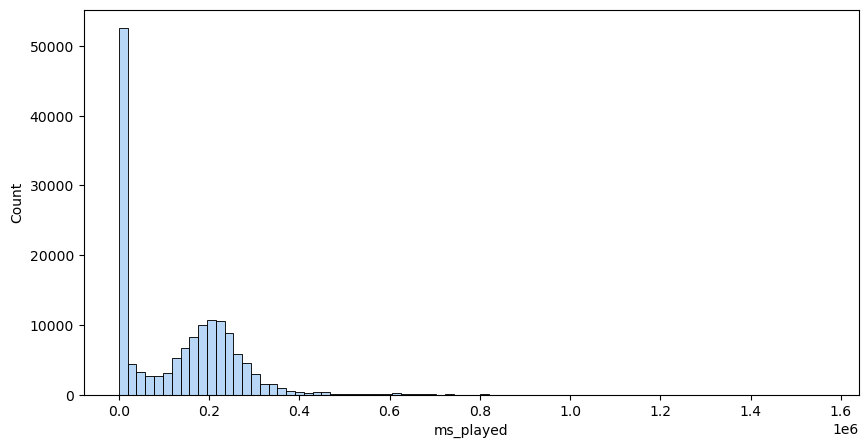

In [40]:
plt.figure(figsize=(10,5))
sns.histplot(cleaned_data,x='ms_played',bins=80)
plt.show()

#### 使用者是否跳過音樂的播放時長

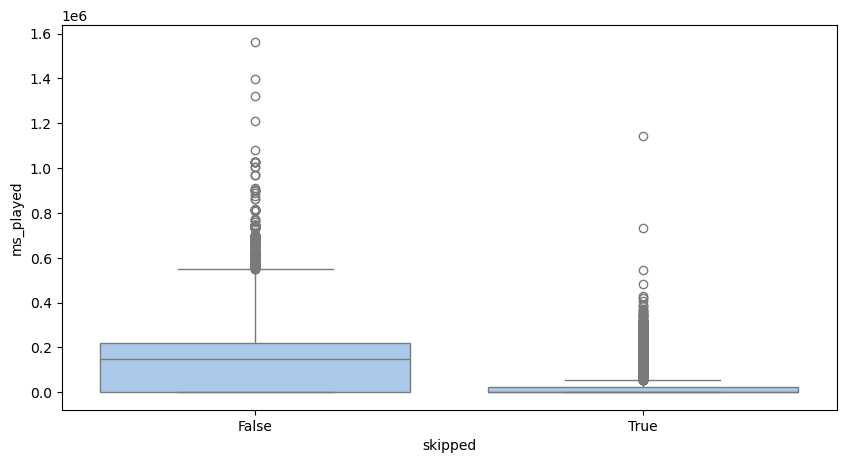

In [51]:
plt.figure(figsize=(10,5))
sns.boxplot(cleaned_data,x="skipped",y="ms_played")
plt.show()

#### 播放平台與跳過歌曲的關係

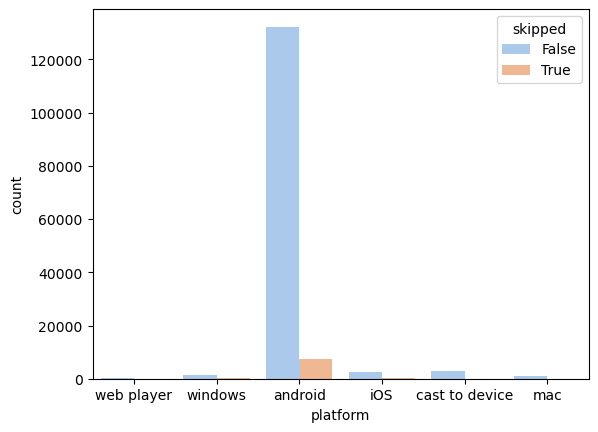

In [42]:
sns.countplot(cleaned_data,x="platform",hue="skipped")
plt.show()

##### 大部分跳過歌曲的使用者播放平台為android。

#### 是否為隨機播放與跳過歌曲的關係

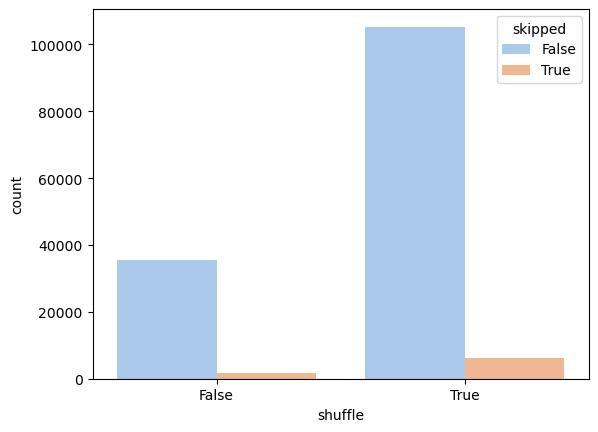

In [45]:
sns.countplot(cleaned_data,x="shuffle",hue="skipped")
plt.show()

##### 音樂為隨機播放的跳過次數相對較高。

#### 音樂播放原因與跳過歌曲的關係

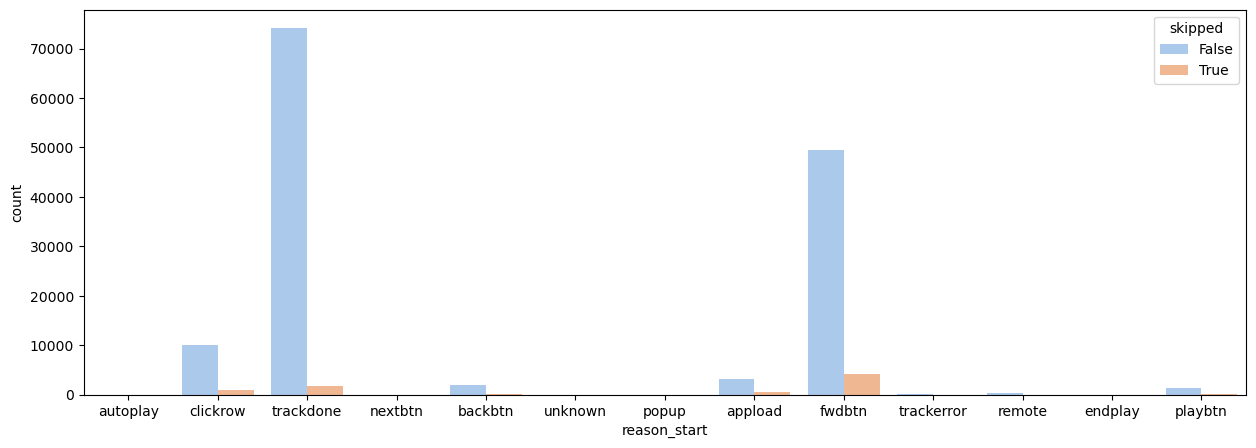

In [48]:
plt.figure(figsize=(15,5))
sns.countplot(cleaned_data,x="reason_start",hue="skipped")
plt.show()

##### 由使用者點擊Spotify推薦歌曲的跳出次數相對較高。

#### 音樂播放時段與跳過歌曲的關係

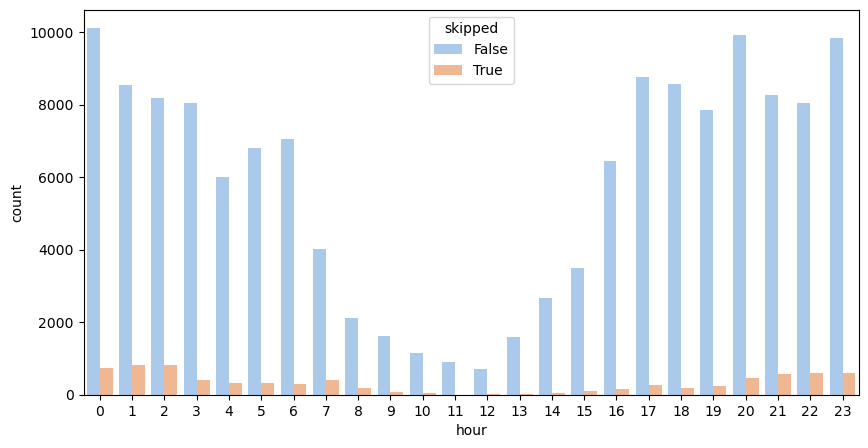

In [53]:
plt.figure(figsize=(10,5))
sns.countplot(cleaned_data,x="hour",hue="skipped")
plt.show()

##### 早上九點至下午兩點的時段，音樂跳出次數相對較低。

### 分析數據

##### 利用清理後的數據，篩選出需要的欄位，並將資料分成訓練用和測試用兩部分，使用訓練資料建立一個邏輯迴歸模型，去預測測試資料中哪些歌曲會被跳過。

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [58]:
lr_data=cleaned_data.copy()

##### 使用者可能無意間點到歌曲，導致播放時常非常短，這些紀錄無法代表「正常聆聽行為」，放進模型會混淆模型學習，需清除。

In [60]:
lr_data=lr_data[lr_data["ms_played"]>3000]
lr_data

,spotify_track_uri,ts,platform,ms_played,track_name,artist_name,album_name,reason_start,reason_end,shuffle,skipped,hour
0,2J3n32GeLmMjwuAzyhcSNe,2013-07-08 02:44:34,web player,3185,"Say It, Just Say It",The Mowgli's,Waiting For The Dawn,autoplay,clickrow,False,False,2
1,1oHxIPqJyvAYHy0PVrDU98,2013-07-08 02:45:37,web player,61865,Drinking from the Bottle (feat. Tinie Tempah),Calvin Harris,18 Months,clickrow,clickrow,False,False,2
2,487OPlneJNni3NWC8SYqhW,2013-07-08 02:50:24,web player,285386,Born To Die,Lana Del Rey,Born To Die - The Paradise Edition,clickrow,unknown,False,False,2
3,5IyblF777jLZj1vGHG2UD3,2013-07-08 02:52:40,web player,134022,Off To The Races,Lana Del Rey,Born To Die - The Paradise Edition,trackdone,clickrow,False,False,2
5,50VNvhzyaSplJCKWchN7a8,2013-07-08 03:17:52,web player,63485,Impossible,James Arthur,Impossible,clickrow,clickrow,False,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...
149842,3F34I6GIzPjDUMSHVpo7RP,2024-12-15 23:05:19,android,280293,Get Out While You Can,James Bay,Chaos And The Calm,trackdone,trackdone,True,False,23
149843,0rpSIjKSmZ2SFO6vmLJpXl,2024-12-15 23:05:45,android,24162,Reunion of Friends,John Williams,Harry Potter and The Chamber of Secrets/ Origi...,trackdone,fwdbtn,True,True,23
149844,3G5iN5QBqMeXx3uZPy8tgB,2024-12-15 23:05:49,android,4368,Young Girls,Bruno Mars,Unorthodox Jukebox,fwdbtn,fwdbtn,True,True,23
149847,0KiZHfashmXDOeUFuxfviV,2024-12-15 23:06:03,android,10672,Color Esperanza,Diego Torres,Mis Favoritas,fwdbtn,fwdbtn,True,True,23


In [61]:
lr_data=lr_data.drop(columns=["ts","spotify_track_uri","track_name","artist_name","album_name"],axis=1)
lr_data.head()

,platform,ms_played,reason_start,reason_end,shuffle,skipped,hour
0,web player,3185,autoplay,clickrow,False,False,2
1,web player,61865,clickrow,clickrow,False,False,2
2,web player,285386,clickrow,unknown,False,False,2
3,web player,134022,trackdone,clickrow,False,False,2
5,web player,63485,clickrow,clickrow,False,False,3


##### 數據存在分類變量無法引入回歸模型，需使用虛擬變量用0和1表示是否屬於該類別。

In [63]:
lr_data=pd.get_dummies(lr_data,columns=["platform","reason_start","reason_end"],dtype=int,drop_first=True)
lr_data.head()

,ms_played,shuffle,skipped,hour,platform_cast to device,platform_iOS,platform_mac,platform_web player,platform_windows,reason_start_autoplay,...,reason_end_fwdbtn,reason_end_logout,reason_end_nextbtn,reason_end_popup,reason_end_reload,reason_end_remote,reason_end_trackdone,reason_end_unexpected-exit,reason_end_unexpected-exit-while-paused,reason_end_unknown
0,3185,False,False,2,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,61865,False,False,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,285386,False,False,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,134022,False,False,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,63485,False,False,3,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
x=lr_data.drop(columns=["skipped"],axis=1)

In [65]:
y=lr_data["skipped"]

#### 建立模型

In [67]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [68]:
model = LogisticRegression(max_iter=5000)
model.fit(x_train, y_train)

LogisticRegression(max_iter=5000)

In [69]:
y_pred = model.predict(x_test)

#### 模型評估

In [71]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

In [72]:
print("評估報告:", classification_report(y_test, y_pred))

評估報告:               precision    recall  f1-score   support

       False       0.97      1.00      0.98     21283
        True       1.00      0.02      0.03       763

    accuracy                           0.97     22046
   macro avg       0.98      0.51      0.51     22046
weighted avg       0.97      0.97      0.95     22046



##### True的recall是0.02，表示只有2%的跳過行為被模型抓出來，雖然accuracy高達 97%，但只是因為大多數使用者沒跳過，代表模型只猜False，就可以有高準確率，因此需處理資料不平衡，使用下採樣方法，並再次建立模型。

In [74]:
df_all = pd.concat([x, y], axis=1)

In [75]:
df_false = df_all[df_all['skipped'] == False]
df_true = df_all[df_all['skipped'] == True]

In [76]:
df_false_down = resample(df_false,
                         replace=False,
                         n_samples=len(df_true),
                         random_state=42)

In [77]:
df_balanced = pd.concat([df_false_down, df_true])

In [78]:
x_balanced = df_balanced.drop('skipped', axis=1)
y_balanced = df_balanced['skipped']

In [79]:
x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.2, random_state=42)

In [80]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [81]:
model = LogisticRegression(max_iter=5000)
model.fit(x_train_scaled, y_train)

LogisticRegression(max_iter=5000)

In [82]:
y_pred = model.predict(x_test_scaled)

In [83]:
print("評估報告:",classification_report(y_test,y_pred))

評估報告:               precision    recall  f1-score   support

       False       0.99      0.79      0.88       794
        True       0.82      0.99      0.90       781

    accuracy                           0.89      1575
   macro avg       0.91      0.89      0.89      1575
weighted avg       0.91      0.89      0.89      1575



##### True類的recall為0.99，模型成功抓出99%的跳過行為。
##### False類precision高達0.99，預測沒跳過也非常準。
##### 模型表現有明顯進步。

#### ROC曲線評估模型

In [86]:
from sklearn.metrics import roc_curve, auc
y_prob = model.predict_proba(x_test_scaled)[:, 1]

In [87]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

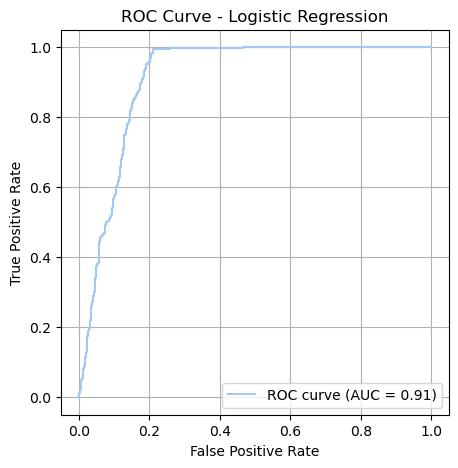

In [88]:
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='best')
plt.grid(True)
plt.show()

##### AUC=0.91代表模型有91%的機會正確區分出跳過/沒跳過的使用者。
##### ROC曲線靠近左上角，代表準確抓出「會跳過」的人，不容易誤判「不會跳過」的人。
##### 模型效果穩定、預測力強。

### 結論

##### 本模型可以針對一首歌的播放情境（平台、播放時段、是否開起隨機播放）預測使用者是否會跳過，即時判斷某些情境下的歌曲跳過風險高，Spotify可調整播放清單順序，降低跳過率。提升用戶黏著度，優化整體使用體驗。